In [1]:
import tensorflow as tf

In [2]:
import os
import sys
import threading

import numpy as np
from PIL import Image

In [3]:
from matplotlib import pyplot as plt
%matplotlib notebook

In [6]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

In [5]:
BASE_DIR = os.path.abspath(os.path.dirname(sys.argv[1]))

In [6]:
BASE_DIR

'/home/yelyu/Work/Dataset/CamVid/Application'

In [7]:
def isImageFile(filePath):
    basename_ext = os.path.splitext(filePath)
    ext= basename_ext[1]
    ext = ext.lower()
    if ext=='.bmp': 
        return True
    if ext=='.png': 
        return True
    if ext=='.jpg': 
        return True
    return False

In [8]:
def filter_for_images(fileList):
    image_list = []
    for i in range(len(fileList)):
        fileName = fileList[i]
        if isImageFile(fileName):
            image_list.append(fileName)
    return image_list

In [9]:
def find_all_images(dir_path = './'):
    ls_files = os.listdir(dir_path)
    print("There are %d files found in total."%len(ls_files))
    image_list = filter_for_images(ls_files)
    print("And %d image files are found."%len(image_list))
    for i in range(len(image_list)):
        image_list[i] =os.path.join(dir_path,image_list[i])
    return image_list

In [26]:
def getBaseNames(fileList):
    fileBaseNames=[]
    for i in range(len(fileList)):
        fileName = fileList[i]
        fileBaseNames.append(os.path.splitext(os.path.basename(fileName))[0])
    return fileBaseNames

In [34]:
def filter_CamVid_ImagePair(imgList,lblList):
    outImgList=[]
    outLblList=[]
    imgBaseNames = getBaseNames(imgList)
    lblBaseNames = getBaseNames(lblList)
    for i in range(len(imgBaseNames)):
        filename = imgBaseNames[i]
        supposedName = filename+"_L"
        if supposedName in lblBaseNames:
            j=lblBaseNames.index(supposedName) 
            outImgList.append(imgList[i])
            outLblList.append(lblList[j])
    return (outImgList,outLblList)

In [28]:
imgList = find_all_images("../701_StillsRaw_full")
lblList = find_all_images("../LabeledApproved_full")

There are 701 files found in total.
And 701 image files are found.
There are 701 files found in total.
And 701 image files are found.


In [29]:
baseNames = getBaseNames(imgList)

In [35]:
outImgList,outLblList = filter_CamVid_ImagePair(imgList,lblList)

In [38]:
print(outImgList[0],outLblList[0])

../701_StillsRaw_full/Seq05VD_f04830.png ../LabeledApproved_full/Seq05VD_f04830_L.png


In [11]:
def pase_Label_File(filePath):
    f = open(filePath,mode='r')
    lines = f.readlines()
    label_items=[]
    for i in range(len(lines)):
        item = lines[i]
        item = item.split()
        r = np.uint8(item[0])
        g = np.uint8(item[1])
        b = np.uint8(item[2])
        name = (item[3])
        print((r,g,b,name))
        label_items.append((r,g,b,name))
    f.close()
    return label_items

In [12]:
def readLabelTxt(filePath):
    basename_ext = os.path.splitext(filePath)
    ext = basename_ext[1].lower()
    label_items = None
    if ext!='.txt':
        raise ValueError('This is not txt file')
    else:
        label_items = pase_Label_File(filePath)
    return label_items  

In [13]:
label_items = readLabelTxt('../label_colors.txt')

(64, 128, 64, 'Animal')
(192, 0, 128, 'Archway')
(0, 128, 192, 'Bicyclist')
(0, 128, 64, 'Bridge')
(128, 0, 0, 'Building')
(64, 0, 128, 'Car')
(64, 0, 192, 'CartLuggagePram')
(192, 128, 64, 'Child')
(192, 192, 128, 'Column_Pole')
(64, 64, 128, 'Fence')
(128, 0, 192, 'LaneMkgsDriv')
(192, 0, 64, 'LaneMkgsNonDriv')
(128, 128, 64, 'Misc_Text')
(192, 0, 192, 'MotorcycleScooter')
(128, 64, 64, 'OtherMoving')
(64, 192, 128, 'ParkingBlock')
(64, 64, 0, 'Pedestrian')
(128, 64, 128, 'Road')
(128, 128, 192, 'RoadShoulder')
(0, 0, 192, 'Sidewalk')
(192, 128, 128, 'SignSymbol')
(128, 128, 128, 'Sky')
(64, 128, 192, 'SUVPickupTruck')
(0, 0, 64, 'TrafficCone')
(0, 64, 64, 'TrafficLight')
(192, 64, 128, 'Train')
(128, 128, 0, 'Tree')
(192, 128, 192, 'Truck_Bus')
(64, 0, 64, 'Tunnel')
(192, 192, 0, 'VegetationMisc')
(0, 0, 0, 'Void')
(64, 192, 0, 'Wall')


In [14]:
def findLabelColorofName(label_items,name):
    for i in range(len(label_items)):
        item = label_items[i]
        if(item[3]==name): return (item[0],item[1],item[2])
    return None

In [15]:
def findLabelNameofColor(label_items,color):
    for i in range(len(label_items)):
        item = label_items[i]
        if((item[0],item[1],item[2])==color or [item[0],item[1],item[2]]==color): return item[3]
    return None

In [16]:
findLabelColorofName(label_items,'VegetationMisc')

(192, 192, 0)

In [17]:
findLabelNameofColor(label_items,[0, 64, 64])

'TrafficLight'

# Write TFRecords

In [215]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [339]:
def convertDataToTFRecord(imagePath,tfrecoredPath):
    with tf.python_io.TFRecordWriter(tfrecoredPath) as writer:
            im = Image.open(imagePath)
            fim = np.array(im).astype(np.float32)
            #shape = np.array(np.shape(im)).astype(np.int64)
            shape = np.array(np.shape(im)).astype(np.float32)
            feature={'shape':_bytes_feature(tf.compat.as_bytes(shape.tostring())),
                     'train/image':_bytes_feature(tf.compat.as_bytes(fim.tostring()))}
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

In [379]:
def convertImageToTFRecords(input_dir_path,output_dir_path):
    print("Input Directory is : %s"%input_dir_path)
    print("Output Directory is : %s"%output_dir_path)
    imgList = find_all_images(input_dir_path)
    convertImageToTFRecord(imgList,output_dir_path)
    print("Conversion Done.")

In [381]:
convertImageToTFRecords("../test","../test")

Input Directory is : ../test
Output Directory is : ../test
There are 12 files found in total.
And 6 image files are found.
OutPut Directory is : ../test
FileTfRecordsName is ../test/0001TP_006720.png.tfrecords
FileTfRecordsName is ../test/0001TP_006750.png.tfrecords
FileTfRecordsName is ../test/0001TP_006780.png.tfrecords
FileTfRecordsName is ../test/0001TP_006810.png.tfrecords
FileTfRecordsName is ../test/0001TP_006840.png.tfrecords
FileTfRecordsName is ../test/0001TP_006690.png.tfrecords
6 files in total are converted
Conversion Done.


In [382]:
convertImageToTFRecords("../701_StillsRaw_full","../tfr_images")

Input Directory is : ../701_StillsRaw_full
Output Directory is : ../tfr_images
There are 702 files found in total.
And 701 image files are found.
OutPut Directory is : ../tfr_images
FileTfRecordsName is ../tfr_images/Seq05VD_f04830.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_06720.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08047.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08023.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08103.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_008400.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f03630.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_009330.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f04530.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f02580.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f00420.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_01980.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_010170.png.tfrecords
F

FileTfRecordsName is ../tfr_images/0016E5_07560.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05340.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05880.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_04980.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_07440.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_008130.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08143.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_007890.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f02730.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03900.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_009960.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08043.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03000.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_01200.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_07650.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08001.png.tfrecords


FileTfRecordsName is ../tfr_images/0016E5_01710.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_07140.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_01140.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08027.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05820.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03690.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03720.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f04350.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08119.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f00870.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05010.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f01620.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_009870.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_01620.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_010020.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_07260.png.tfreco

FileTfRecordsName is ../tfr_images/Seq05VD_f04740.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f03690.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08135.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_06150.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_07985.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08107.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f01170.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f04170.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_04440.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05550.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_01380.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f01230.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08079.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f05070.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08053.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03780.png.tfreco

FileTfRecordsName is ../tfr_images/0016E5_08101.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_06090.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f01410.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f03360.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08640.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f03780.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_00720.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_06930.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f03720.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08087.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08520.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_05700.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_008040.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_007020.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_009000.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08009.png.tfrecords


FileTfRecordsName is ../tfr_images/Seq05VD_f03750.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_009210.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03360.png.tfrecords
FileTfRecordsName is ../tfr_images/0001TP_010230.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f01110.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08190.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_08123.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03180.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f01560.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_00390.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f03960.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_06360.png.tfrecords
FileTfRecordsName is ../tfr_images/Seq05VD_f02010.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f02040.png.tfrecords
FileTfRecordsName is ../tfr_images/0016E5_00901.png.tfrecords
FileTfRecordsName is ../tfr_images/0006R0_f02790.png.t

In [ ]:
convertImageToTFRecords("../LabeledApproved_full","../tft_labels")

# Read TFRecords

In [368]:
def readDatafromTFRecord(sess,tfrecoredPath):
    feature={'shape':tf.FixedLenFeature([],tf.string),
             'train/image':tf.FixedLenFeature([],tf.string)}
    filename_queue = tf.train.string_input_producer([tfrecoredPath],num_epochs=1)
    reader = tf.TFRecordReader()
    _,serialized_example =reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,features=feature)
    image = tf.decode_raw(features['train/image'],tf.float32)
    shape = tf.cast(tf.decode_raw(features['shape'],tf.float32),tf.int32)
    image = tf.reshape(image,shape)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    img ,val_shape= sess.run([image,shape])
    print(val_shape)
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()
    # Stop the threads
    coord.request_stop()
    # Wait for threads to stop
    
    coord.join(threads)
    

[720 960   3]


<IPython.core.display.Javascript object>


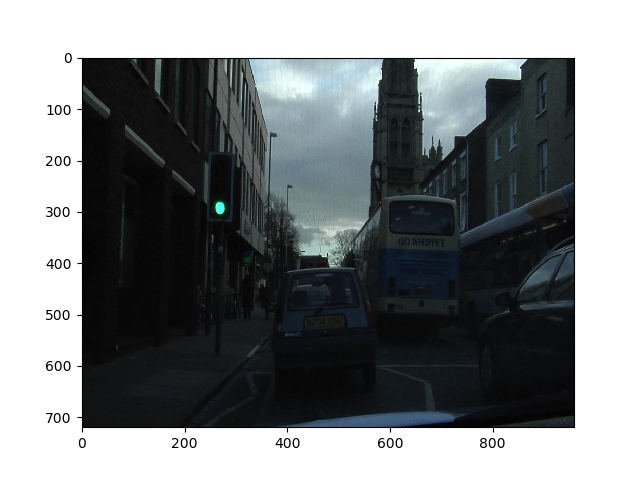

In [369]:
with tf.Session() as sess:
    readDatafromTFRecord(sess,'/home/yelyu/Work/Dataset/CamVid/test/0001TP_006690.png.tfrecords')

# Read Image directly

# Test My Module

In [13]:
import imp
import ImageReader
imp.reload(ImageReader)
from ImageReader import BatchDataReader
from matplotlib import pyplot as plt
import numpy as np
%matplotlib notebook

In [14]:
trainingParams = ImageReader.TrainingParams()
trainingParams.set_batchSize(10)
trainingParams.set_epochs(2)
trainingParams.set_lr(1.0)
trainingParams.set_UseRandomShuffle(True)
dataPairListGetter = ImageReader.getCamVidDataPairsList
reader = BatchDataReader("../701_StillsRaw_full","../LabeledApproved_full",
                         '../label_colors.txt',dataPairListGetter,
                         trainingParams)
reader.begin_epoch()

Initializing Batch Dataset Reader...
Looking for images files...
There are 701 files found in total.
in which, 701 image files are found.
Looking for label files...
There are 701 files found in total.
in which, 701 image files are found.
Filtering for image correct label pairs...
There are 701 image pairs in total
Parsing txt file for labels...
There are 32 classes in total


In [5]:
(batch_img,batch_lbl) = reader.next_batch()

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


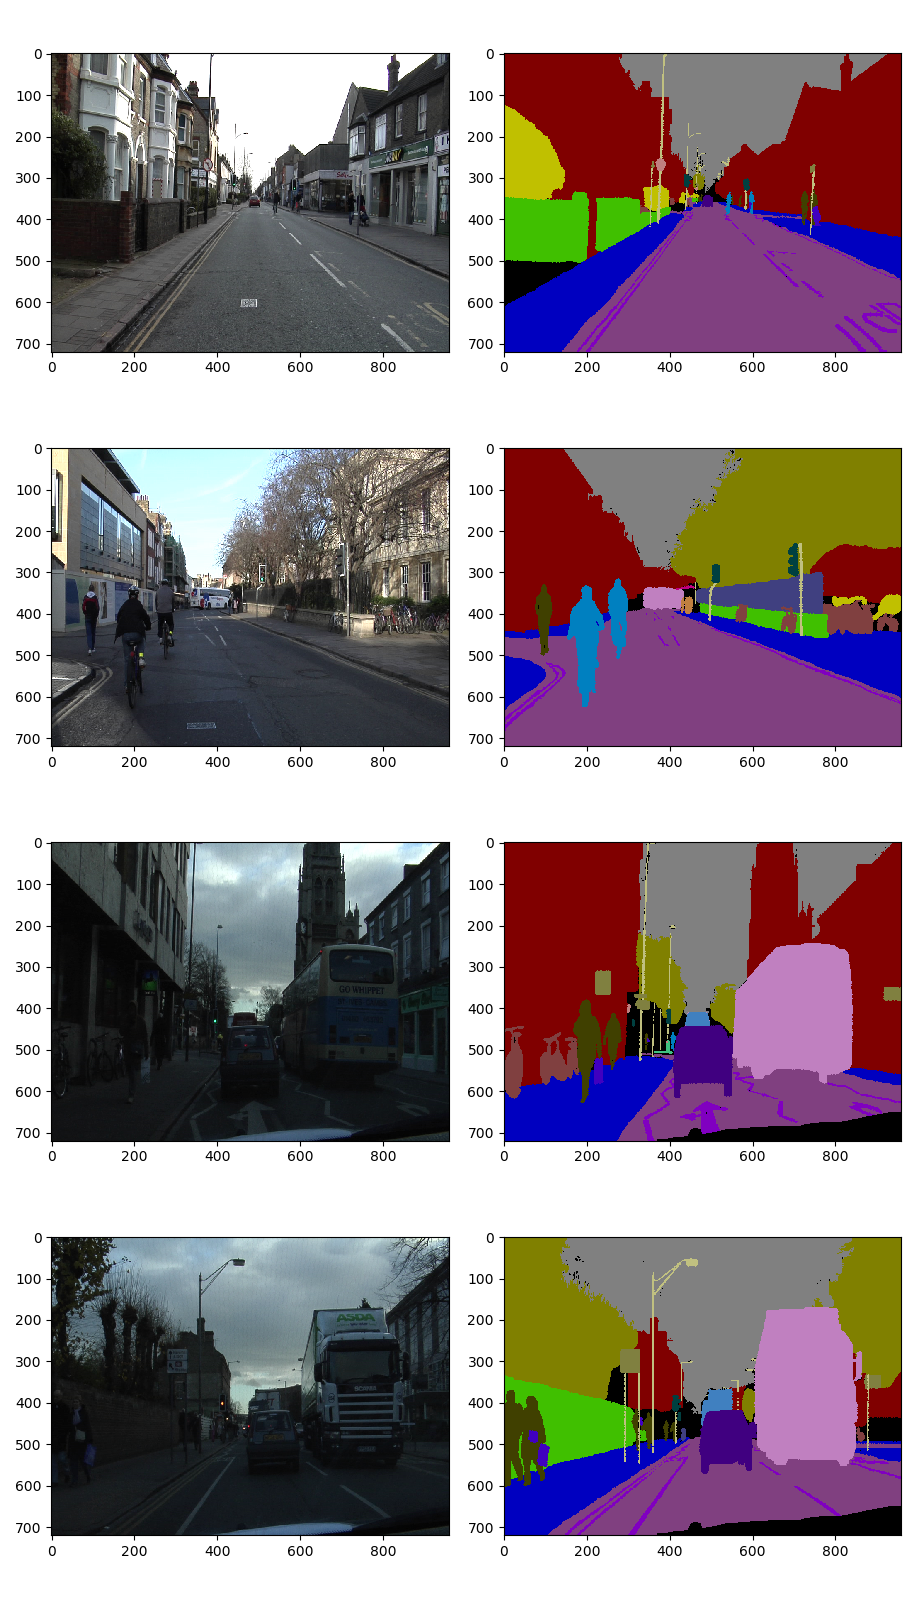

In [16]:
reader.show_batch_image_pair(batch_img,batch_lbl,np.arange(4,8))